In [30]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# 
import keras
from keras.models import Model
from keras.regularizers import l2
from keras.activations import relu
from keras.layers import LSTM, Bidirectional, BatchNormalization, Dropout, LeakyReLU, Dense, Input, Concatenate, Activation, LeakyReLU, Convolution2D

## Utils

In [2]:
def show_img(image, title=""):
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.title(f"{title}")
    plt.show()
    
def apply_kernel(image: np.array, kernel: np.array):
    # edges = cv2.filter2D(src=image, cv2.CV_64F, kernel=kernel)
    edges = cv2.filter2D(src=image, ddepth=-1, kernel=kernel)
    img_edges = np.uint8(np.absolute(edges))  # make to unsigned 8 bit int
    return img_edges

## Load Data

In [3]:
datapath = "./data.csv"
df = pd.read_csv(datapath)
df.head()

,filepath,filename,target,class
0,./data/desert/desert(1017).jpg,desert(1017).jpg,3,desert
1,./data/green_area/Forest_610.jpg,Forest_610.jpg,2,green_area
2,./data/desert/desert(1087).jpg,desert(1087).jpg,3,desert
3,./data/cloudy/train_2904.jpg,train_2904.jpg,0,cloudy
4,./data/cloudy/train_6891.jpg,train_6891.jpg,0,cloudy


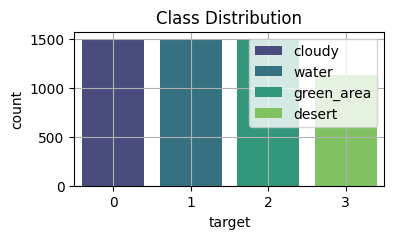

In [4]:
plt.figure(figsize=(4, 2))
sns.countplot(data=df, x="target", palette="viridis", hue='class')
plt.title("Class Distribution")
plt.grid(True)
plt.legend()
plt.show()

In [5]:
data = df['filepath'].values
images: list = list()

for ip in data:
    image = cv2.imread(ip, 0)
    dims = (200, 200)
    image = cv2.resize(image, dims, interpolation=cv2.INTER_AREA)
    images.append(image)

## Feature Extraction

#### laplacian_kernel

In [6]:
filter_imgs : list = list()
laplacian_kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
gs_dims = (5, 5) # Gaussian smoothing
# 
for image in images:
    # image = cv2.GaussianBlur(image, gs_dims, 0)
    lk_img = apply_kernel(image, laplacian_kernel)
    filter_imgs.append(lk_img)
filter_imgs = np.array(filter_imgs)

## Data Split And Normalisation

In [7]:
filter_imgs = filter_imgs / 255.0

In [8]:
x_train, x_test, y_train, y_test  = train_test_split(filter_imgs, df['target'], test_size=0.2, random_state=18 ) 
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((4504, 200, 200), (1127, 200, 200), (4504,), (1127,))

## Train

#### conv net

In [9]:
y_train = keras.utils.to_categorical(y_train, num_classes=4)
y_train.shape

(4504, 4)

In [10]:
x_train.shape, y_train.shape

((4504, 200, 200), (4504, 4))

In [14]:
BATCH_SIZE = 16
DROPOUT_RATE = 0.4
LEARNING_RATE: int = 0.1e-3
INPUT_SHAPE = filter_imgs.shape[1:]
NUM_CLASSES = y_train.shape[-1]

#
input = Input(shape=(200, 200, 1), name="first lstm input layer")
x = Convolution2D(32, 3, data_format='channels_last', activation="relu", input_shape=(200, 200, 1))(input)
x = keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = keras.layers.Flatten()(x)
x = Dense(100)(x)
x = Dropout(DROPOUT_RATE)(x)
# 
output = Dense(NUM_CLASSES, activation="softmax")(x)
# 
model = Model(inputs=input, outputs=output)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"] )

# keras.utils.plot_model(model, show_layer_names=True, show_shapes=True, show_layer_activations=True, show_trainable=True )
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first lstm input layer (In  [(None, 200, 200, 1)]     0         
 putLayer)                                                       
                                                                 
 conv2d_3 (Conv2D)           (None, 198, 198, 32)      320       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 99, 99, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 313632)            0         
                                                                 
 dense_2 (Dense)             (None, 100)               31363300  
                                                                 
 dropout_1 (Dropout)         (None, 100)               0   

In [15]:
y_eval = keras.utils.to_categorical(y_test, NUM_CLASSES)
x_test.shape, y_eval.shape

((1127, 200, 200), (1127, 4))

In [16]:
x_train.shape, y_train.shape

((4504, 200, 200), (4504, 4))

In [17]:
EPOCHS = 10
model_history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, 
                        #   validation_data=(x_test, y_eval), 
                          validation_split=0.2,
                          epochs=EPOCHS, verbose=1 )

Epoch 1/20
226/226 [==============================] - 48s 209ms/step - loss: 0.6461 - accuracy: 0.7680 - val_loss: 0.3117 - val_accuracy: 0.8590
Epoch 2/20
226/226 [==============================] - 40s 176ms/step - loss: 0.1969 - accuracy: 0.9331 - val_loss: 0.1632 - val_accuracy: 0.9401
Epoch 3/20
226/226 [==============================] - 46s 202ms/step - loss: 0.0721 - accuracy: 0.9833 - val_loss: 0.2840 - val_accuracy: 0.9112
Epoch 4/20
226/226 [==============================] - 40s 178ms/step - loss: 0.0397 - accuracy: 0.9920 - val_loss: 0.1524 - val_accuracy: 0.9623
Epoch 5/20
226/226 [==============================] - 46s 201ms/step - loss: 0.0214 - accuracy: 0.9950 - val_loss: 0.1404 - val_accuracy: 0.9667
Epoch 6/20
226/226 [==============================] - 47s 207ms/step - loss: 0.0373 - accuracy: 0.9895 - val_loss: 0.1136 - val_accuracy: 0.9678
Epoch 7/20
226/226 [==============================] - 47s 207ms/step - loss: 0.0102 - accuracy: 0.9989 - val_loss: 0.1692 - val_ac

#### Save Model To File

In [31]:
# model.save("./models/laplacian_convnet.keras")

## Evaluate

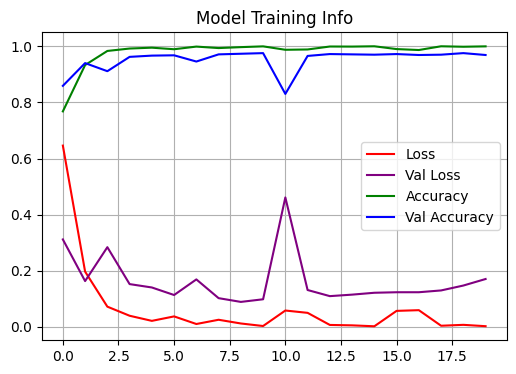

In [19]:
s = model_history.history

plt.figure(figsize=(6, 4))
plt.plot(s['loss'], label="Loss", color="red")
plt.plot(s['val_loss'], label="Val Loss", color="purple" )
plt.plot(s['accuracy'], label="Accuracy", color="green" )
plt.plot(s['val_accuracy'], label="Val Accuracy", color="blue" )
plt.title("Model Training Info")
plt.grid(True)
# y = [0, 1]
# plt.yticks(range(min(y), max(y)+1, 1))
plt.legend()
plt.show()

In [20]:
y_preds = model.predict(x_test)
y_preds = np.argmax(y_preds, axis=1)
y_preds

36/36 [==============================] - 3s 66ms/step


array([3, 3, 2, ..., 2, 1, 0])

In [21]:
accuracy_score(y_test, y_preds)

0.9804791481810116

In [22]:
print(classification_report(y_test, y_preds, zero_division=1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       290
           1       0.98      0.96      0.97       332
           2       0.95      0.98      0.96       294
           3       1.00      1.00      1.00       211

    accuracy                           0.98      1127
   macro avg       0.98      0.98      0.98      1127
weighted avg       0.98      0.98      0.98      1127



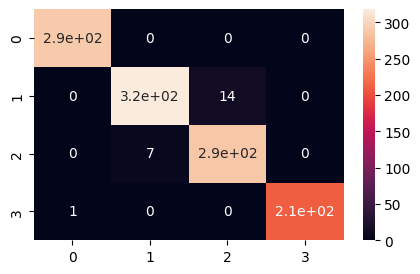

In [23]:
plt.figure(figsize=(5, 3))
sns.heatmap(confusion_matrix(y_test, y_preds), annot=True)
plt.show()

## Test With Eval Data

In [57]:
eval_path = "./eval.csv"
eval = pd.read_csv(eval_path)
eval.head()

,filepath,filename,target,class
0,./data/sacair_data/validation/desert/desert(65...,desert(657).jpg,3,desert
1,./data/sacair_data/validation/desert/desert(66...,desert(665).jpg,3,desert
2,./data/sacair_data/validation/desert/desert(75...,desert(75).jpg,3,desert
3,./data/sacair_data/validation/water/SeaLake_40...,SeaLake_403.jpg,1,water
4,./data/sacair_data/validation/green_area/Fores...,Forest_2867.jpg,2,green_area


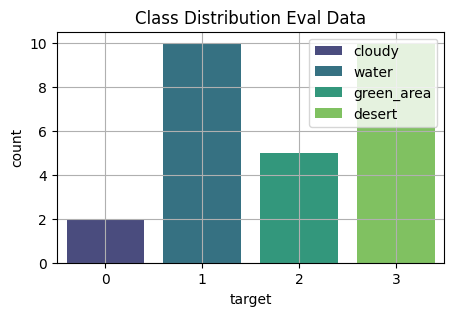

In [58]:
plt.figure(figsize=(5, 3))
sns.countplot(data=eval, x="target", palette="viridis", hue='class')
plt.title("Class Distribution Eval Data")
plt.grid(True)
plt.legend()
plt.show()

### Preprocess the image data

In [71]:
images_paths = eval['filepath'].values
y_eval = eval['target'].values

eval_images: list = list()

for ip in images_paths:
    image = cv2.imread(ip, 0)
    dims = (200, 200)
    image = cv2.resize(image, dims, interpolation=cv2.INTER_AREA)
    eval_images.append(image)

In [72]:
eval_imgs : list = list()
laplacian_kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
gs_dims = (5, 5) # Gaussian smoothing
# 
for image in eval_images:
    # image = cv2.GaussianBlur(image, gs_dims, 0)
    lk_img = apply_kernel(image, laplacian_kernel)
    eval_imgs.append(lk_img)
eval_imgs = np.array(eval_imgs)
eval_imgs.shape

(27, 200, 200)

In [73]:
eval_preds = model.predict(eval_imgs)
eval_preds = np.argmax(eval_preds, axis=1)
eval_preds

1/1 [==============================] - 0s 152ms/step


array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3])

In [74]:
accuracy_score(y_eval, eval_preds)

0.37037037037037035

In [75]:
y_eval, eval_preds

(array([3, 3, 3, 1, 2, 3, 3, 1, 1, 1, 1, 2, 2, 2, 2, 0, 0, 1, 1, 3, 1, 3,
        1, 3, 3, 1, 3]),
 array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3]))

In [76]:
print(classification_report(y_eval, eval_preds, zero_division=1))

              precision    recall  f1-score   support

           0       1.00      0.00      0.00         2
           1       1.00      0.00      0.00        10
           2       1.00      0.00      0.00         5
           3       0.37      1.00      0.54        10

    accuracy                           0.37        27
   macro avg       0.84      0.25      0.14        27
weighted avg       0.77      0.37      0.20        27



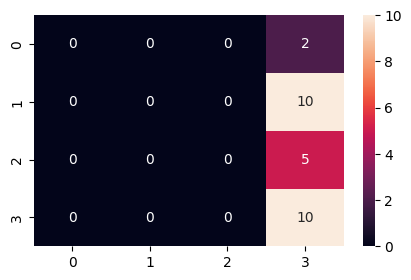

In [77]:
plt.figure(figsize=(5, 3))
sns.heatmap(confusion_matrix(y_eval, eval_preds), annot=True)
plt.show()